<a href="https://colab.research.google.com/github/dimna21/ML_Final_Project/blob/main/model_experiment_LGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

walmart_recruiting_store_sales_forecasting_path = kagglehub.competition_download('walmart-recruiting-store-sales-forecasting')

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/walmart-recruiting-store-sales-forecasting/train.csv.zip
/kaggle/input/walmart-recruiting-store-sales-forecasting/sampleSubmission.csv.zip
/kaggle/input/walmart-recruiting-store-sales-forecasting/stores.csv
/kaggle/input/walmart-recruiting-store-sales-forecasting/features.csv.zip
/kaggle/input/walmart-recruiting-store-sales-forecasting/test.csv.zip


# import tables

In [ ]:
import zipfile
import pandas as pd

# Unzip the files
with zipfile.ZipFile('/kaggle/input/walmart-recruiting-store-sales-forecasting/train.csv.zip', 'r') as zip_ref:
    zip_ref.extractall('/kaggle/working')

with zipfile.ZipFile('/kaggle/input/walmart-recruiting-store-sales-forecasting/sampleSubmission.csv.zip', 'r') as zip_ref:
    zip_ref.extractall('/kaggle/working')

with zipfile.ZipFile('/kaggle/input/walmart-recruiting-store-sales-forecasting/features.csv.zip', 'r') as zip_ref:
    zip_ref.extractall('/kaggle/working')

with zipfile.ZipFile('/kaggle/input/walmart-recruiting-store-sales-forecasting/test.csv.zip', 'r') as zip_ref:
    zip_ref.extractall('/kaggle/working')


# Unzipped files in /kaggle/working/
train = pd.read_csv('/kaggle/working/train.csv')
test = pd.read_csv('/kaggle/working/test.csv')
features = pd.read_csv('/kaggle/working/features.csv')
stores = pd.read_csv('/kaggle/input/walmart-recruiting-store-sales-forecasting/stores.csv')

# cleaning preprocessors

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class BaseMerger(BaseEstimator, TransformerMixin):
    def __init__(self, features, stores):
        self.feature_store = features.merge(stores, how='inner', on='Store')
        self.feature_store['Date'] = pd.to_datetime(self.feature_store['Date'])

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X['Date'] = pd.to_datetime(X['Date'])
        merged = X.merge(self.feature_store, how='inner', on=['Store', 'Date', 'IsHoliday'])
        merged = merged.sort_values(by=['Store', 'Dept', 'Date']).reset_index(drop=True)
        return merged

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.type_mapping = {'A': 3, 'B': 2, 'C': 1}
        self.holiday_mapping = {False: 0, True: 1}

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        if 'Type' in X.columns:
            X['Type'] = X['Type'].map(self.type_mapping)

        if 'IsHoliday' in X.columns:
            X['IsHoliday'] = X['IsHoliday'].map(self.holiday_mapping)

        return X

class MarkdownFiller(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.markdown_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
        self.mean_values = {}

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        # Fill markdowns with 0
        for col in self.markdown_cols:
            if col in X.columns:
                X[col] = X[col].fillna(0.0)


        return X

# FE preprocessors

In [ ]:
from scipy import stats
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd

class TrendInterpolator(BaseEstimator, TransformerMixin):
    """
    Interpolates missing CPI and Unemployment using a recent N‑month linear trend per Store.
    """
    def __init__(self, lookback_months: int = 12):
        self.lookback_months = lookback_months

    def fit(self, X, y=None):
        # Nothing to learn—just return self
        return self

    def transform(self, df: pd.DataFrame) -> pd.DataFrame:
        data = df.copy()

        # If no date column, bail out
        if 'Date' not in data.columns:
            return data

        # Ensure datetime
        data['Date'] = pd.to_datetime(data['Date'])

        # Only try to interpolate if those columns exist
        do_cpi = 'CPI' in data.columns
        do_unemp = 'Unemployment' in data.columns

        # If neither exists, skip
        if not (do_cpi or do_unemp):
            return data

        out_frames = []
        # Group by store (or the whole DF if Store missing)
        group_key = ['Store'] if 'Store' in data.columns else []
        for _, group in data.groupby(group_key, as_index=False):
            block = group.sort_values('Date').copy()
            # Numeric time for regression
            block['date_num'] = block['Date'].astype('int64')

            # Helper to interpolate a single column
            def _interp(col):
                mask = block[col].isna()
                if not mask.any():
                    return

                known = block.loc[~mask, ['Date', 'date_num', col]]
                if len(known) < 2:
                    return

                # Only use recent lookback_months
                cutoff = known['Date'].max() - pd.DateOffset(months=self.lookback_months)
                recent = known[known['Date'] >= cutoff]
                if len(recent) < 2:
                    return

                slope, intercept, *_ = stats.linregress(
                    recent['date_num'], recent[col]
                )
                block.loc[mask, col] = (
                    slope * block.loc[mask, 'date_num'] + intercept
                )

            if do_cpi:
                _interp('CPI')
            if do_unemp:
                _interp('Unemployment')

            block.drop(columns='date_num', inplace=True)
            out_frames.append(block)

        # Re‑concatenate in original order
        filled = pd.concat(out_frames, ignore_index=True)
        # If original df had a different order, reindex to match
        return filled.loc[df.index].reset_index(drop=True)

class AdvancedSeasonalFeatures(BaseEstimator, TransformerMixin):
    """
    Creates sophisticated seasonal and cyclical features
    """
    def __init__(self):
        # Define holiday periods more precisely
        self.holiday_periods = {
            'thanksgiving_period': [
                ('2010-11-19', '2010-11-26'),
                ('2011-11-18', '2011-11-25'),
                ('2012-11-16', '2012-11-23'),
                ('2013-11-22', '2013-11-29')
            ],
            'christmas_period': [
                ('2010-12-17', '2010-12-31'),
                ('2011-12-16', '2011-12-30'),
                ('2012-12-21', '2012-12-28'),
                ('2013-12-20', '2013-12-27')
            ],
            'superbowl_period': [
                ('2010-02-05', '2010-02-12'),
                ('2011-02-04', '2011-02-11'),
                ('2012-02-03', '2012-02-10'),
                ('2013-02-01', '2013-02-08')
            ],
            'labor_day_period': [
                ('2010-09-03', '2010-09-10'),
                ('2011-09-02', '2011-09-09'),
                ('2012-08-31', '2012-09-07'),
                ('2013-08-30', '2013-09-06')
            ]
        }

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        df = X.copy()
        df['Date'] = pd.to_datetime(df['Date'])

        # Basic date parts
        df['Day'] = df['Date'].dt.day
        df['Month'] = df['Date'].dt.month
        df['Year'] = df['Date'].dt.year
        df['week_of_year'] = df['Date'].dt.isocalendar().week

        # Cyclical encoding of month
        df['month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
        df['month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)

        # Cyclical encoding of week
        df['week_sin'] = np.sin(2 * np.pi * df['week_of_year'] / 52)
        df['week_cos'] = np.cos(2 * np.pi * df['week_of_year'] / 52)

        # Compute days to and since holidays per year
        df['Days_to_Thanksgiving'] = np.nan
        df['Days_to_Christmas'] = np.nan
        df['days_since_thanksgiving'] = np.nan
        df['days_since_christmas'] = np.nan

        for year in [2010, 2011, 2012, 2013]:
            mask = df['Year'] == year
            if not mask.any():
                continue
            thanksgiving = pd.to_datetime(f'{year}-11-24')
            christmas = pd.to_datetime(f'{year}-12-25')

            df.loc[mask, 'Days_to_Thanksgiving'] = (thanksgiving - df.loc[mask, 'Date']).dt.days
            df.loc[mask, 'Days_to_Christmas'] = (christmas - df.loc[mask, 'Date']).dt.days
            df.loc[mask, 'days_since_thanksgiving'] = (df.loc[mask, 'Date'] - thanksgiving).dt.days
            df.loc[mask, 'days_since_christmas'] = (df.loc[mask, 'Date'] - christmas).dt.days

        # Advanced holiday period flags
        for holiday_name, periods in self.holiday_periods.items():
            df[f'{holiday_name}_flag'] = 0
            for start, end in periods:
                mask = (df['Date'] >= start) & (df['Date'] <= end)
                df.loc[mask, f'{holiday_name}_flag'] = 1

        # Pre- and post-holiday intensity
        df['pre_thanksgiving_intensity'] = np.where(
            (df['Days_to_Thanksgiving'] <= 14) & (df['Days_to_Thanksgiving'] > 0),
            15 - df['Days_to_Thanksgiving'], 0
        )
        df['pre_christmas_intensity'] = np.where(
            (df['Days_to_Christmas'] <= 21) & (df['Days_to_Christmas'] > 0),
            22 - df['Days_to_Christmas'], 0
        )
        df['post_holiday_effect'] = np.where(
            ((df['days_since_thanksgiving'] > 0) & (df['days_since_thanksgiving'] <= 7)) |
            ((df['days_since_christmas'] > 0) & (df['days_since_christmas'] <= 14)),
            1, 0
        )

        # Drop intermediate columns
        df = df.drop(columns=['week_of_year'], errors='ignore')

        return df

class StatisticalSalesFeatures(BaseEstimator, TransformerMixin):
    """
    Computes and attaches statistical sales features:
      - Mean, std, median per Store
      - Mean, std, median per Dept
      - Mean, std, median per (Store, Dept)
    Fallback logic for unseen combos:
      sd_* → store_* → global
      dept_* → global
    """
    def fit(self, X, y=None):
        df = X.copy()
        # 1) Store-level
        self.store_stats_ = (
            df.groupby('Store')['Weekly_Sales']
              .agg(['mean', 'std', 'median'])
              .rename(columns={
                  'mean': 'store_mean_sales',
                  'std':  'store_std_sales',
                  'median':'store_median_sales'
              })
        )
        # 2) Dept-level
        self.dept_stats_ = (
            df.groupby('Dept')['Weekly_Sales']
              .agg(['mean', 'std', 'median'])
              .rename(columns={
                  'mean': 'dept_mean_sales',
                  'std':  'dept_std_sales',
                  'median':'dept_median_sales'
              })
        )
        # 3) Store-Dept level
        self.store_dept_stats_ = (
            df.groupby(['Store','Dept'])['Weekly_Sales']
              .agg(['mean','std','median'])
              .rename(columns={
                  'mean': 'sd_mean_sales',
                  'std':  'sd_std_sales',
                  'median':'sd_median_sales'
              })
        )
        # 4) Global fallbacks (for dept-level only)
        global_mean   = df['Weekly_Sales'].mean()
        global_std    = df['Weekly_Sales'].std()
        global_median = df['Weekly_Sales'].median()
        self.global_stats_ = {
            'dept_mean_sales':   global_mean,
            'dept_std_sales':    global_std,
            'dept_median_sales': global_median
        }
        return self

    def transform(self, X):
        df = X.copy()
        # Merge in all three levels
        df = df.merge(self.store_stats_,
                      how='left',
                      left_on='Store',
                      right_index=True)
        df = df.merge(self.dept_stats_,
                      how='left',
                      left_on='Dept',
                      right_index=True)
        df = df.merge(self.store_dept_stats_,
                      how='left',
                      left_on=['Store','Dept'],
                      right_index=True)

        # Fallback sd_* → store_*
        for stat in ['mean','std','median']:
            sd_col    = f'sd_{stat}_sales'
            store_col = f'store_{stat}_sales'
            df[sd_col] = df[sd_col].fillna(df[store_col])

        # Fallback dept_* → global
        for col, global_val in self.global_stats_.items():
            df[col] = df[col].fillna(global_val)

        return df

class EconomicInteractionFeatures(BaseEstimator, TransformerMixin):
    """
    Adds key economic and markdown interaction features:
      - Economic pressure (CPI × Unemployment) and purchasing power
      - Markdown aggregates and holiday markdown boost
    """
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        df = X.copy()

        # Economic indicators
        if 'CPI' in df.columns and 'Unemployment' in df.columns:
            df['economic_pressure']   = df['CPI'] * df['Unemployment']
            df['purchasing_power']    = df['CPI'] / (df['Unemployment'] + 1e-8)

        # Markdown effectiveness
        md_cols = [c for c in df.columns if c.startswith('MarkDown')]
        if md_cols:
            df['total_markdown']    = df[md_cols].sum(axis=1)
            df['markdown_count']    = (df[md_cols] > 0).sum(axis=1)
            df['avg_markdown']      = df['total_markdown'] / (df['markdown_count'] + 1e-8)
            if 'IsHoliday' in df.columns:
                df['holiday_markdown_boost'] = df['IsHoliday'].astype(int) * df['total_markdown']

        return df

class LagFeatureTransformer(BaseEstimator, TransformerMixin):
    def __init__(self,
                 lags=[1, 2, 3, 5, 26, 52],
                 rolling_windows=[4, 8],
                 drop_na=False):
        self.lags = lags
        self.rolling_windows = rolling_windows
        self.drop_na = drop_na
        self.history_for_prediction = pd.DataFrame()
        self.max_lookback = max(max(self.lags), max(self.rolling_windows) if self.rolling_windows else 0)

    def fit(self, X, y=None):
        # During fit, we capture the tail of the training data for test prediction
        df = X.copy()
        df['Date'] = pd.to_datetime(df['Date'])
        df_sorted = df.sort_values(by=["Store", "Dept", "Date"])

        relevant_cols = ["Store", "Dept", "Date", "Weekly_Sales"]

        # For each Store-Dept combination, get the last 'max_lookback' rows
        self.history_for_prediction = (
            df_sorted.groupby(["Store", "Dept"])
            .tail(self.max_lookback)[relevant_cols]
            .copy()
        )

        return self

    def transform(self, X):
        df = X.copy()
        df['Date'] = pd.to_datetime(df['Date'])

        # Check if Weekly_Sales is present in the input X
        weekly_sales_present_in_input = "Weekly_Sales" in df.columns

        combined_df = None

        # If in prediction mode (Weekly_Sales is missing from input X) and we have history
        if not weekly_sales_present_in_input and not self.history_for_prediction.empty:
            stores_depts_in_X = df[["Store", "Dept"]].drop_duplicates()
            relevant_history = self.history_for_prediction.merge(
                stores_depts_in_X, on=["Store", "Dept"], how="inner"
            )

            # Add Weekly_Sales column filled with NaN for the prediction rows
            if 'Weekly_Sales' not in df.columns:
                df['Weekly_Sales'] = np.nan

            combined_df = pd.concat([relevant_history, df], ignore_index=True)
            combined_df = combined_df.sort_values(by=["Store", "Dept", "Date"])

            # Replace 0s with NaN for proper lag calculation (like your classmate)
            combined_df['Weekly_Sales'] = combined_df['Weekly_Sales'].replace(0, np.nan)

        else:  # During training/validation, Weekly_Sales is present in X
            combined_df = df.copy()
            combined_df = combined_df.sort_values(by=["Store", "Dept", "Date"])
            # Replace 0s with NaN for proper lag calculation
            combined_df['Weekly_Sales'] = combined_df['Weekly_Sales'].replace(0, np.nan)

        # Create DateOrdinal
        combined_df['DateOrdinal'] = combined_df['Date'].map(pd.Timestamp.toordinal)

        # Calculate Lag features
        for lag in self.lags:
            col = f"lag_{lag}"
            combined_df[col] = combined_df.groupby(["Store", "Dept"])["Weekly_Sales"].shift(lag)
            # Fill NaNs from shift with 0 (simple fallback like your classmate)
            combined_df[col] = combined_df[col].fillna(0)

        # Calculate Rolling means
        for window in self.rolling_windows:
            col = f"rolling_mean_{window}"
            combined_df[col] = combined_df.groupby(["Store", "Dept"])["Weekly_Sales"].transform(
                lambda x: x.rolling(window=window, min_periods=1).mean()
            )
            # Fill NaNs from rolling with 0
            combined_df[col] = combined_df[col].fillna(0)

        # If we were in prediction mode, return only the prediction rows
        if not weekly_sales_present_in_input:
            final_df = combined_df.tail(len(df)).drop(columns=["Weekly_Sales"], errors="ignore")
        else:
            final_df = combined_df.copy()
            # Fill Weekly_Sales NaNs that weren't for lag/rolling calculation
            final_df['Weekly_Sales'] = final_df['Weekly_Sales'].fillna(0)
            # Ensure non-negative sales
            final_df["Weekly_Sales"] = final_df["Weekly_Sales"].apply(lambda x: max(0, x))

        # Handle NaN values for training data if drop_na is True
        if self.drop_na and weekly_sales_present_in_input:
            required = [f'lag_{l}' for l in self.lags] + [f'rolling_mean_{w}' for w in self.rolling_windows]
            final_df = final_df.dropna(subset=required).reset_index(drop=True)

        return final_df

# preprocess for training

In [ ]:
from sklearn.pipeline import Pipeline

features_interp = TrendInterpolator().fit_transform(features)
cleaning_pipeline = Pipeline([
    ("merge",       BaseMerger(features_interp, stores)),
    ("fill_markdowns", MarkdownFiller()),
    ("encode",      CategoricalEncoder())
])

fe_full_pipeline = Pipeline([
    ("stats",       StatisticalSalesFeatures()),
    ("seasonal",    AdvancedSeasonalFeatures()),
    ("econ",        EconomicInteractionFeatures()),
    ("lag",         LagFeatureTransformer()),
])

df_clean = cleaning_pipeline.fit_transform(train)
df_final = fe_full_pipeline.fit_transform(df_clean)

df_clean.columns, df_clean.shape, df_final.columns, df_final.shape

(Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Temperature',
        'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
        'MarkDown5', 'CPI', 'Unemployment', 'Type', 'Size'],
       dtype='object'),
 (421570, 16),
 Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Temperature',
        'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
        'MarkDown5', 'CPI', 'Unemployment', 'Type', 'Size', 'store_mean_sales',
        'store_std_sales', 'store_median_sales', 'dept_mean_sales',
        'dept_std_sales', 'dept_median_sales', 'sd_mean_sales', 'sd_std_sales',
        'sd_median_sales', 'Day', 'Month', 'Year', 'month_sin', 'month_cos',
        'week_sin', 'week_cos', 'Days_to_Thanksgiving', 'Days_to_Christmas',
        'days_since_thanksgiving', 'days_since_christmas',
        'thanksgiving_period_flag', 'christmas_period_flag',
        'superbowl_period_flag', 'labor_day_period_flag',
        'pre_thanksgiving_intensity', 

# submission generating function

In [ ]:
def generate_submission(model, X_test, output_filename):
    """
    Generates a Kaggle submission CSV using a trained model and global 'test' DataFrame.

    Parameters:
    - model: Trained model with a .predict() method
    - X_test: Test features to predict on
    - output_filename: Name of the output CSV file
    """
    y_pred = model.predict(X_test)

    submission = pd.DataFrame({
        "Id": test["Store"].astype(str) + "_" +
              test["Dept"].astype(str) + "_" +
              test["Date"].astype(str),
        "Weekly_Sales": y_pred
    })

    submission.to_csv(output_filename, index=False)
    print(f"✅ Wrote {output_filename}")


# split for trianing

In [ ]:
import pandas as pd

def split_sales_data(df: pd.DataFrame, split_date : pd.Timestamp = pd.Timestamp('2012-02-15')):
    """
    Splits sales data into train and test sets based on a provided date,
    including the 'Weekly_Sales' column in both dataframes.

    Parameters:
    - df (pd.DataFrame): The full dataset with features and target.
    - split_date (pd.Timestamp): The cutoff date for train-test split.

    Returns:
    - df_train, df_test: Tuple of training and test dataframes including 'Weekly_Sales'.
    """
    # Ensure Date is in datetime format
    df = df.copy()
    df['Date'] = pd.to_datetime(df['Date'])

    # Split the data based on date
    train_mask = df['Date'] < split_date
    test_mask = df['Date'] >= split_date

    df_train = df[train_mask].copy()
    df_test = df[test_mask].copy()

    return df_train, df_test


# mlflow setup for trianing

In [ ]:
%pip install -q dagshub mlflow
import mlflow
import dagshub

dagshub.init(repo_owner='nkhar21', repo_name='ML_Final_Project', mlflow=True)
mlflow.set_tracking_uri("https://dagshub.com/nkhar21/ML_Final_Project.mlflow")

experiment_name = "Training_LGBM"
mlflow.set_experiment(experiment_name)

Note: you may need to restart the kernel to use updated packages.


Initialized MLflow to track repo "nkhar21/ML_Final_Project"

Repository nkhar21/ML_Final_Project initialized!

<Experiment: artifact_location='mlflow-artifacts:/6a741971b9654b44bb67be973b9158f8', creation_time=1753553303287, experiment_id='8', last_update_time=1753553303287, lifecycle_stage='active', name='Training_LGBM', tags={}>

# training helper functions

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import mlflow
import mlflow.xgboost
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def wmae(y_true, y_pred, w):
    """Weighted MAE (holidays count 5×) with NaN handling."""
    # Create mask for finite values
    mask = np.isfinite(y_true) & np.isfinite(y_pred) & np.isfinite(w)

    if not mask.any():
        print("⚠️ All values are NaN/infinite in WMAE calculation")
        return np.nan

    # Filter to finite values only
    y_true_clean = y_true[mask]
    y_pred_clean = y_pred[mask]
    w_clean = w[mask]

    if w_clean.sum() == 0:
        print("⚠️ Sum of weights is zero in WMAE calculation")
        return np.nan

    return (w_clean * np.abs(y_true_clean - y_pred_clean)).sum() / w_clean.sum()

def log_lgbm_params(model):
    p = model.get_params()
    mlflow.log_params({
        "n_estimators":     p["n_estimators"],
        "max_depth":        p["max_depth"],
        "num_leaves":       p["num_leaves"],
        "learning_rate":    p["learning_rate"],
        "subsample":        p.get("subsample"),
        "colsample_bytree": p.get("colsample_bytree"),
        "lambda_l1":        p.get("lambda_l1"),
        "lambda_l2":        p.get("lambda_l2"),
        "objective":        p.get("objective"),
        "random_state":     p.get("random_state"),
        "n_jobs":           p.get("n_jobs"),
    })


def evaluate_and_plot(model, X, y, w, split):
    """
    1) Predict & compute metrics (WMAE, MAE, RMSE, R2)
    2) Log metrics and four diagnostic plots to MLflow.
    """
    preds = model.predict(X)

    # 1) Metrics
    metrics = {
        "WMAE": wmae(y, preds, w),
        "MAE":  mean_absolute_error(y, preds),
        "RMSE": np.sqrt(mean_squared_error(y, preds)),
        "R2":   r2_score(y, preds),
    }
    mlflow.log_metrics({f"{split}_{k}": v for k,v in metrics.items()})
    print(f"[{split.upper()}] " + "  ".join(f"{k}={v:.4f}" for k,v in metrics.items()))

    # 2) Plot 1: Actual vs Predicted
    fig, ax = plt.subplots(figsize=(6,6))
    # filter non‑finite
    mask = np.isfinite(y) & np.isfinite(preds)
    if mask.any():
        ax.scatter(y[mask], preds[mask], alpha=0.3, s=10)
        mn = min(y[mask].min(), preds[mask].min())
        mx = max(y[mask].max(), preds[mask].max())
        ax.plot([mn,mx], [mn,mx], 'r--', linewidth=1)
        ax.set_xlim(mn, mx)
        ax.set_ylim(mn, mx)
    ax.set_xlabel("Actual Weekly Sales")
    ax.set_ylabel("Predicted Weekly Sales")
    ax.set_title(f"{split.capitalize()} Actual vs Predicted")
    plt.show()  # Show the plot
    mlflow.log_figure(fig, f"{split}_actual_vs_pred.png")
    plt.close(fig)

    # 3) Plot 2: Residuals vs Predicted
    residuals = y - preds
    mask = np.isfinite(preds) & np.isfinite(residuals)
    fig, ax = plt.subplots(figsize=(6,4))
    if mask.any():
        ax.scatter(preds[mask], residuals[mask], alpha=0.3, s=10)
        ax.hlines(0, preds[mask].min(), preds[mask].max(), colors='r', linestyles='--')
    ax.set_xlabel("Predicted Weekly Sales")
    ax.set_ylabel("Residuals (Actual–Pred)")
    ax.set_title(f"{split.capitalize()} Residuals vs Predicted")
    plt.show()  # Show the plot
    mlflow.log_figure(fig, f"{split}_residuals.png")
    plt.close(fig)

    # 4) Plot 3: WMAE‑weighted error distribution
    # Create mask for finite values
    mask = np.isfinite(y) & np.isfinite(preds) & np.isfinite(w)
    if mask.any():
        weighted_errors = w[mask] * np.abs(y[mask] - preds[mask])
        if weighted_errors.size > 0:
            fig, ax = plt.subplots(figsize=(6,4))
            ax.hist(weighted_errors, bins=50, density=True, alpha=0.7)
            ax.set_xlabel("Weighted Absolute Error")
            ax.set_ylabel("Density")
            ax.set_title(f"{split.capitalize()} WMAE Error Dist.")
            plt.show()  # Show the plot
            mlflow.log_figure(fig, f"{split}_wmae_error_dist.png")
            plt.close(fig)
        else:
            print(f"⚠️  {split} weighted_errors empty after filtering, skipping Plot 3")
    else:
        print(f"⚠️  {split} all values non-finite, skipping Plot 3")

    return metrics

def plot_overfitting(train_metrics, val_metrics):
    """
    Plot bar chart comparing train vs val for each metric.
    R² is plotted on a secondary axis due to scale differences.
    """
    metrics = list(train_metrics.keys())
    train_vals = [train_metrics[m] for m in metrics]
    val_vals   = [val_metrics[m]   for m in metrics]

    # Separate R2 from the rest for plotting on secondary y-axis
    primary_metrics = [m for m in metrics if m != "R2"]
    secondary_metrics = ["R2"]

    x_primary = np.arange(len(primary_metrics))
    x_secondary = [len(primary_metrics)]  # position R2 to the right

    fig, ax1 = plt.subplots(figsize=(10, 5))

    # Primary metrics (WMAE, MAE, RMSE)
    train_primary = [train_metrics[m] for m in primary_metrics]
    val_primary   = [val_metrics[m]   for m in primary_metrics]
    ax1.bar(x_primary - 0.2, train_primary, width=0.4, label='Train', color='skyblue')
    ax1.bar(x_primary + 0.2, val_primary,   width=0.4, label='Val',   color='orange')
    ax1.set_ylabel("Error Metrics")
    ax1.set_xticks(list(x_primary) + x_secondary)
    ax1.set_xticklabels(primary_metrics + secondary_metrics)
    ax1.legend(loc="upper left")

    # R² on secondary y-axis
    ax2 = ax1.twinx()
    train_r2 = train_metrics.get("R2", None)
    val_r2   = val_metrics.get("R2", None)
    if train_r2 is not None and val_r2 is not None:
        ax2.bar([x_secondary[0] - 0.2], [train_r2], width=0.4, label='Train R²', color='green')
        ax2.bar([x_secondary[0] + 0.2], [val_r2],   width=0.4, label='Val R²',   color='red')
        ax2.set_ylabel("R² Score")
        ax2.set_ylim(0, 1)

    # Combine legends
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(handles1 + handles2, labels1 + labels2, loc='upper left')

    plt.title("Train vs Val Metrics (Primary & R²)")
    plt.tight_layout()
    plt.show()
    mlflow.log_figure(fig, "overfitting_metrics.png")
    plt.close(fig)

# training 1 - simple - no fe

In [ ]:
from sklearn.pipeline import Pipeline

features_interp = TrendInterpolator().fit_transform(features)
cleaning_pipeline = Pipeline([
    ("merge",       BaseMerger(features_interp, stores)),
    ("fill_markdowns", MarkdownFiller()),
    ("encode",      CategoricalEncoder())
])

df_clean = cleaning_pipeline.fit_transform(train)
train_clean, test_clean = split_sales_data(df_clean)

w_train = train_clean["IsHoliday"].map({1: 5, 0: 1}).values
w_test = test_clean["IsHoliday"].map({1: 5, 0: 1}).values

train_clean.columns, test_clean.shape, train_clean.shape, test_clean.shape

(Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Temperature',
        'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
        'MarkDown5', 'CPI', 'Unemployment', 'Type', 'Size'],
       dtype='object'),
 (109610, 16),
 (311960, 16),
 (109610, 16))

In [ ]:
y_train = train_clean['Weekly_Sales']
y_test = test_clean['Weekly_Sales']
X_train  = train_clean.drop(['Weekly_Sales', 'Date'], axis=1)
X_test   = test_clean.drop(['Weekly_Sales', 'Date'], axis=1)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((311960, 14), (311960,), (109610, 14), (109610,))

In [ ]:
import mlflow.lightgbm
import lightgbm as lgb
model = lgb.LGBMRegressor(
        n_estimators=1000,
        max_depth=9,
        num_leaves=255,
        learning_rate=0.1,
        subsample=0.9,
        colsample_bytree=0.8,
        lambda_l1=0.0,
        lambda_l2=0.0,
        objective="regression",
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )

[TRAIN] WMAE=1729.5934  MAE=1607.2613  RMSE=3332.4824  R2=0.9789


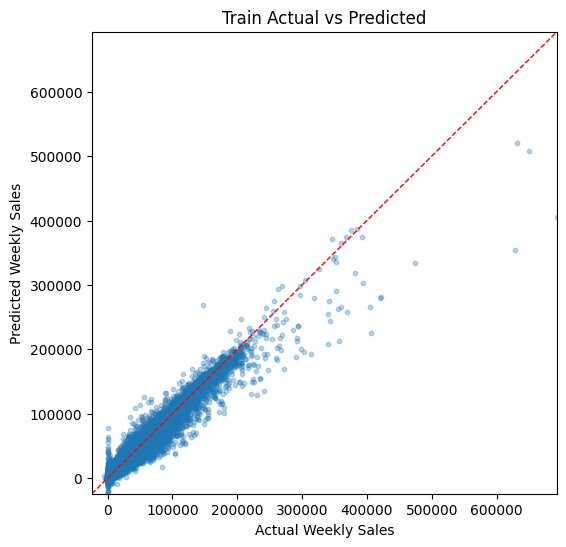

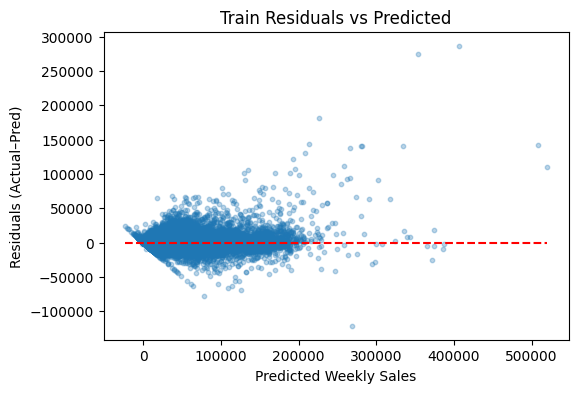

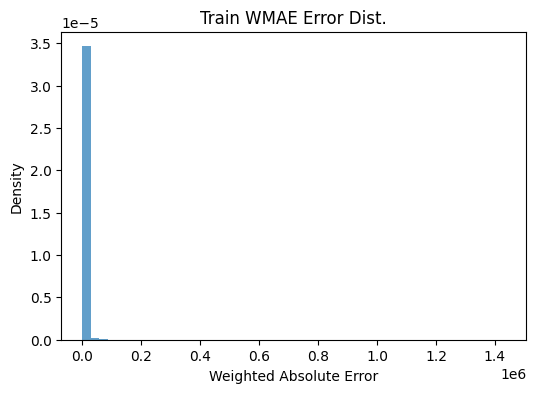

[TEST] WMAE=3017.1750  MAE=2930.5267  RMSE=5402.6857  R2=0.9401


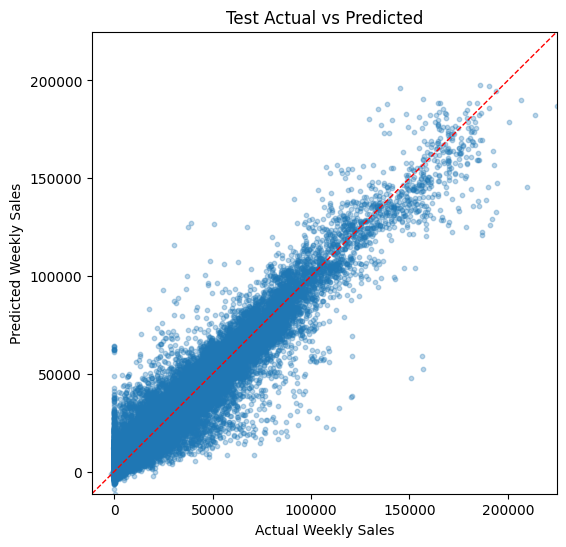

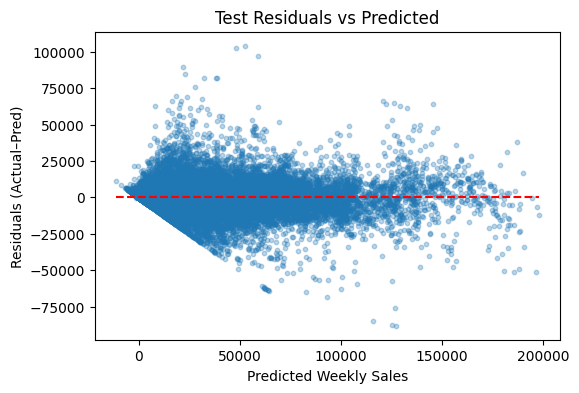

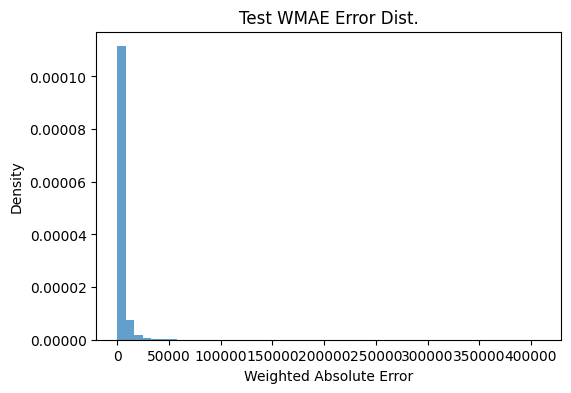

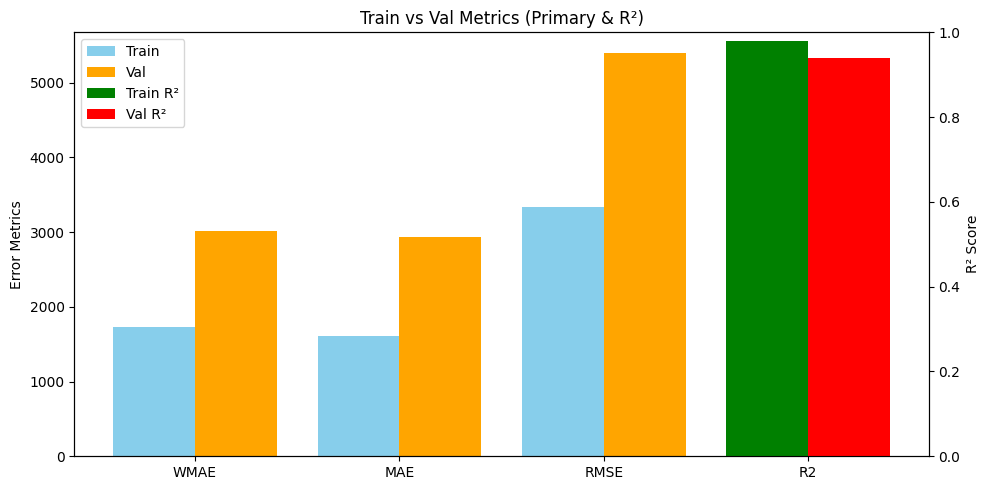

🏃 View run LGBM_no_fe at: https://dagshub.com/nkhar21/ML_Final_Project.mlflow/#/experiments/8/runs/2fc3c41affe64a4383c13385b58393e1
🧪 View experiment at: https://dagshub.com/nkhar21/ML_Final_Project.mlflow/#/experiments/8


In [ ]:
import mlflow
import mlflow.xgboost
import xgboost as xgb

mlflow.end_run()
mlflow.set_experiment("Training_LGBM")

with mlflow.start_run(run_name="LGBM_no_fe"):
    log_lgbm_params(model)

    model.fit(X_train, y_train)

    train_metrics = evaluate_and_plot(model, X_train, y_train, w_train, split="train")
    test_metrics  = evaluate_and_plot(model, X_test,  y_test,  w_test,  split="test")
    plot_overfitting(train_metrics, test_metrics)

# all triaining got deleted from here for some reason, but are on mlflow

# generate submission

In [ ]:
from sklearn.pipeline import Pipeline

features_interp = TrendInterpolator().fit_transform(features)
pipeline = Pipeline([
    ("merge",       BaseMerger(features_interp, stores)),
    ("fill_markdowns", MarkdownFiller()),
    ("encode",      CategoricalEncoder()),
    ("stats",       StatisticalSalesFeatures()),
    ("seasonal",    AdvancedSeasonalFeatures()),
    ("econ",        EconomicInteractionFeatures()),
    # ("lag",         LagFeatureTransformer())
])

train_final = pipeline.fit_transform(train)
test_final = pipeline.transform(test)

y_train = train_final['Weekly_Sales']
X_train  = train_final.drop(['Weekly_Sales', 'Date'], axis=1)
X_test   = test_final.drop(['Date'], axis=1)
X_train.shape, y_train.shape, X_test.shape

((421570, 47), (421570,), (115064, 47))

In [ ]:
import lightgbm as lgb
best_model = lgb.LGBMRegressor(
        n_estimators=3000,
        max_depth=7,
        num_leaves=127,
        learning_rate=0.05,
        subsample=0.9,
        bagging_fraction=0.8,
        colsample_bytree=0.8,
        lambda_l1=0.0,
        lambda_l2=0.0,
        objective="regression",
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )
best_model.fit(X_train,y_train)

LGBMRegressor(bagging_fraction=0.8, colsample_bytree=0.8, lambda_l1=0.0,
              lambda_l2=0.0, learning_rate=0.05, max_depth=7, n_estimators=3000,
              n_jobs=-1, num_leaves=127, objective='regression',
              random_state=42, subsample=0.9, verbose=-1)

In [ ]:
generate_submission(best_model, X_test, "LGBM_FULL_no_lag_fe.csv")

✅ Wrote LGBM_FULL_no_lag_fe.csv
